In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 30 08:17:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    51W / 400W |   7496MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
# from visualization import ANN
# %matplotlib widget

ModuleNotFoundError: ignored

In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10


class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return pos_1, pos_2, target


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

In [ ]:
# check whether run in Colab
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.5.4 

from timm import create_model


model_name = "convnext_small"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
convnext_model = create_model(model_name, pretrained=False).to(device)
# convnext_model.stem[0] = torch.nn.Conv2d(3, 96, kernel_size=(3,3), stride=(1,1), padding=(1,1))
convnext_model.head = convnext_model.head[0:3]
convnext_model.head

Running in Colab.
device =  cuda


Sequential(
  (global_pool): SelectAdaptivePool2d (pool_type=avg, flatten=Identity())
  (norm): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.models.resnet import resnet50


class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in convnext_model.named_children():
            # if name == 'conv1':
            #     module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            # if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
            self.f.append(module)
        # ----------------------------------------------------------------------
        # START OF YOUR CODE
        # ----------------------------------------------------------------------
        # Task 1
        # set a neural network base encoder self.f
        # hint: nn.Sequential

        self.f = nn.Sequential(*self.f)

        # set a small neural network projection head
        # Dense-> Relu-> Dense (2-layer MLP to project the representation to a 128-dimensional latent space and 
        # the representation is 2048-dimensional here)

        self.g = nn.Sequential(nn.Linear(768, 1000, bias=True), 
                               nn.GELU(), 
                               nn.Linear(1000, feature_dim, bias=True))
        
        # ----------------------------------------------------------------------
        # END OF YOUR CODE
        # ----------------------------------------------------------------------
    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)

In [ ]:
from tqdm import tqdm
# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader):
    net.eval()
    total_top1, total_top5, total_num, out_bank = 0.0, 0.0, 0, []

    test_bar = tqdm(test_data_loader)
    with torch.no_grad():
        # generate feature bank
        i=0
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)
            # print('out: ', out.shape)
            if i==0:
                out_bank = out
                targets = target 
                i = i + 1
            else:
                out_bank = torch.cat((out_bank, out), 0)
                targets = torch.cat((targets,target),0)
        
    return out_bank, targets


batch_size=128
memory_data = CIFAR10Pair(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = CIFAR10Pair(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


import torch
torch.cuda.is_available()
checkpoint=torch.load('/content/128_0.1_200_128_500_model.pth', map_location='cuda:0')
feature_dim=128
model = Model(feature_dim).cuda()
model.load_state_dict(checkpoint['model_state_dict'],strict=False)

embeddings, targets = test(model, memory_loader, test_loader)
print('embeddings: ', embeddings.shape)
# targets = torch.unsqueeze(targets, -1).cpu()
print('targets: ', targets.shape)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


100%|██████████| 79/79 [00:02<00:00, 30.71it/s]


embeddings:  torch.Size([10000, 128])
targets:  torch.Size([10000])


In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(embeddings.cpu().numpy())

In [ ]:
num_points = X_embedded.shape[0]
num_points

10000

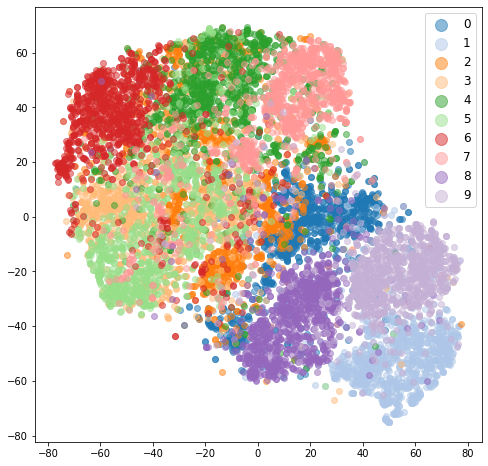

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = targets.cpu().numpy()==lab
    ax.scatter(X_embedded[indices,0],X_embedded[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()
